Straight-forward mapping the verilog benchmarks to the required format

In [1]:
import re
import os

In [2]:
def extract_input_output_pairs(filename):
    original_v = ''
    with open(filename, 'rt') as f:
        original_v = f.read()
    
    signal_lists = []
    
    output_strings = []
    
    matches = re.findall(r'\n\s*([A-Za-z0-9_]+)\s+([A-Za-z0-9_]+)\s*\((.*)\).*;', original_v)
    for m in matches:
        #print(m[1])
        gate_type = m[0]
        gate_name = m[1]
        signal_list = re.split(r'[\s\(\),]+', m[2])
        signal_list = list(filter(lambda x: len(x) > 0, signal_list))
        input_list = signal_list[::2]
        signal_list = signal_list[1::2]
        
        relations = list([gate_type + x for x in input_list])
        
        #print(signal_list)
        gate_output = signal_list[0]
        signal_list = signal_list[1:]
        
        tab = '\t'
        
        for signal, relation in zip(signal_list, relations):
            output_string = f"{gate_name}{tab}{relation}{tab}{signal}\n"
            output_strings.append(output_string)
            
        output_strings.append(f"{gate_output}{tab}wire{tab}{gate_name}\n")
        
    return output_strings

In [3]:
strings = extract_input_output_pairs('benches/c2670_T001.v')
with open('./graph/train', 'wt') as f:
        f.writelines(strings)
with open('./graph/valid', 'wt') as f:
        f.writelines(strings)
with open('./graph/test', 'wt') as f:
        f.writelines(strings)

Running KBC model

In [4]:

from kbc import process_datasets

In [5]:
path = './graph'
files = ['train', 'valid', 'test']
entities, relations = set(), set()
for f in files:
    file_path = os.path.join(path, f)
    to_read = open(file_path, 'r')
    for line in to_read.readlines():
        lhs, rel, rhs = line.strip().split('\t')
        entities.add(lhs)
        entities.add(rhs)
        relations.add(rel)
    to_read.close()

entities_to_id = {x: i for (i, x) in enumerate(sorted(entities))}
relations_to_id = {x: i for (i, x) in enumerate(sorted(relations))}
print("{} entities and {} relations".format(len(entities), len(relations)))
n_relations = len(relations)
n_entities = len(entities)
#process_datasets.prepare_dataset('./graph','test_graph_2')

1541 entities and 21 relations


In [6]:
from kbc.datasets import Dataset
from kbc.models import CP, ComplEx
from kbc.regularizers import F2, N3
from kbc.optimizers import KBCOptimizer

import torch
from torch import optim

import tqdm

dataset = Dataset('test_graph_2')
examples = torch.from_numpy(dataset.get_train().astype('int64'))
model = ComplEx(dataset.get_shape(), 200)
regularizer = N3(0.00001)

device = 'cuda'
model.to(device)

optimizer = KBCOptimizer(model, regularizer, optim.Adagrad(model.parameters(), lr=0.1), batch_size=256)

cur_loss = 0
curve = {'train': [], 'valid': [], 'test': []}

max_epochs = 30 

for e in tqdm.tqdm (range(max_epochs)):
    cur_loss = optimizer.epoch(examples)

    

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


In [7]:
print(model.embeddings[0].weight.shape)
model.get_queries(torch.tensor([[1540,1],[1540,20],[1,3,],[3,2]]).to("cuda"))

torch.Size([1541, 400])


tensor([[-0.0319, -0.1397, -0.0516,  ..., -0.1331, -0.0933,  0.0309],
        [-0.0997,  0.0526, -0.0178,  ...,  0.1698, -0.0690,  0.0911],
        [ 0.0939, -0.0007, -0.0343,  ..., -0.5400, -0.2763, -0.4578],
        [ 0.1018, -0.1448, -0.4423,  ...,  0.0954,  0.1747, -0.0746]],
       device='cuda:0', grad_fn=<CatBackward>)

In [8]:
trojan_orig ="""troj1_0U1	nor3s1.DIN1	troj1_0n2
troj1_0U1	nor3s1.DIN2	troj1_0n3
troj1_0U1	nor3s1.DIN3	Trigger_en1_0
troj1_0n1	wire	troj1_0U1
troj1_0U2	nnd4s1.DIN1	n850
troj1_0U2	nnd4s1.DIN2	n836
troj1_0U2	nnd4s1.DIN3	n804
troj1_0U2	nnd4s1.DIN4	troj1_0n3
n872	wire	troj1_0U2
troj1_0U3	nnd4s1.DIN1	n437
troj1_0U3	nnd4s1.DIN2	n319
troj1_0U3	nnd4s1.DIN3	troj1_0n4
troj1_0U3	nnd4s1.DIN4	troj1_0n2
n801	wire	troj1_0U3
troj1_0U4	i1s1.DIN	troj1_0n4
n361	wire	troj1_0U4
troj1_0U5	or5s1.DIN1	n373
troj1_0U5	or5s1.DIN2	n491
troj1_0U5	or5s1.DIN3	n490
troj1_0U5	or5s1.DIN4	troj1_0n5
troj1_0U5	or5s1.DIN5	troj1_0n1
n482	wire	troj1_0U5
troj1_0U6	or5s1.DIN1	n725
troj1_0U6	or5s1.DIN2	n699
troj1_0U6	or5s1.DIN3	n559
troj1_0U6	or5s1.DIN4	n527
troj1_0U6	or5s1.DIN5	troj1_0n5
n887	wire	troj1_0U6
trojan1_0	xor2s1.DIN1	Trigger_en1_0
trojan1_0	xor2s1.DIN2	n681
tempn681	wire	trojan1_0
"""

trojan ="""troj1_0U1	nor3s1.DIN1	troj1_0n2
troj1_0U1	nor3s1.DIN2	troj1_0n3
troj1_0U1	nor3s1.DIN3	Trigger_en1_0
troj1_0U2	nnd4s1.DIN1	n850
troj1_0U2	nnd4s1.DIN2	n836
troj1_0U2	nnd4s1.DIN3	n804
troj1_0U2	nnd4s1.DIN4	troj1_0n3
troj1_0U3	nnd4s1.DIN1	n437
troj1_0U3	nnd4s1.DIN2	n319
troj1_0U3	nnd4s1.DIN3	troj1_0n4
troj1_0U3	nnd4s1.DIN4	troj1_0n2
troj1_0U4	i1s1.DIN	troj1_0n4
troj1_0U5	or5s1.DIN1	n373
troj1_0U5	or5s1.DIN2	n491
troj1_0U5	or5s1.DIN3	n490
troj1_0U5	or5s1.DIN4	troj1_0n5
troj1_0U5	or5s1.DIN5	troj1_0n1
troj1_0U6	or5s1.DIN1	n725
troj1_0U6	or5s1.DIN2	n699
troj1_0U6	or5s1.DIN3	n559
troj1_0U6	or5s1.DIN4	n527
troj1_0U6	or5s1.DIN5	troj1_0n5
trojan1_0	xor2s1.DIN1	Trigger_en1_0
trojan1_0	xor2s1.DIN2	n681
"""


trojan_idx = []

for line in trojan.splitlines():
        lhs, rel, rhs = line.strip().split('\t')
        idx = [entities_to_id[lhs], relations_to_id[rel], entities_to_id[rhs]]
        trojan_idx.append(idx)
        print( idx )

all_idx = []
to_read = open("./graph/train", 'r')
for line in to_read.readlines():
    lhs, rel, rhs = line.strip().split('\t')
    idx = [entities_to_id[lhs], relations_to_id[rel], entities_to_id[rhs]]
    all_idx.append(idx)
to_read.close()

print(len(all_idx))
for idx in trojan_idx:
    if idx in all_idx:
        all_idx.remove(idx)

print(len(all_idx))

[1529, 10, 1536]
[1529, 11, 1537]
[1529, 12, 205]
[1530, 4, 1462]
[1530, 5, 1448]
[1530, 6, 1416]
[1530, 7, 1537]
[1531, 4, 1049]
[1531, 5, 931]
[1531, 6, 1538]
[1531, 7, 1536]
[1532, 1, 1538]
[1533, 13, 985]
[1533, 14, 1103]
[1533, 15, 1102]
[1533, 16, 1539]
[1533, 17, 1535]
[1534, 13, 1337]
[1534, 14, 1311]
[1534, 15, 1171]
[1534, 16, 1139]
[1534, 17, 1539]
[1540, 19, 205]
[1540, 20, 1293]
1967
1943


In [9]:
embeddings_high_dim = model.get_queries(torch.tensor(all_idx).to("cuda"))
trojan_embeddings_high_dim = model.get_queries(torch.tensor(trojan_idx).to("cuda"))


In [10]:
print(embeddings_high_dim.shape)

torch.Size([1943, 400])


In [11]:
np_embeddings_high_dim = embeddings_high_dim.cpu().detach().numpy()
np_trojan_embeddings_high_dim = trojan_embeddings_high_dim.cpu().detach().numpy()

print (np_trojan_embeddings_high_dim.shape)

(24, 400)


(1943, 2)


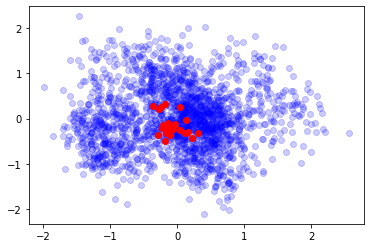

[-1.86519042e-04 -1.55423712e-02  4.73644910e-03 -2.82642078e-02
 -3.87166515e-02 -1.41426250e-02  2.83546690e-02 -1.42618676e-03
  1.63669195e-02 -1.36096040e-02  8.21376033e-03  9.06575657e-03
  4.03673446e-04 -1.38699729e-02 -1.87264115e-03 -2.52030566e-02
 -3.94228753e-03  8.82687233e-03 -1.94382726e-03 -4.85197175e-03
 -3.27918604e-02 -7.53959222e-03  4.03060503e-02  6.84855646e-03
 -5.22693759e-03 -5.26153203e-03 -1.04643521e-03  2.95824837e-02
  3.84455663e-03  3.03809787e-03  1.84356095e-03 -1.80508103e-02
  3.38315545e-03 -2.57668854e-03 -1.41217355e-02 -2.27388251e-03
 -1.33000137e-02  7.50680780e-03  1.43488813e-02 -1.19525623e-02
  2.85030867e-04  1.91682037e-02 -1.00803539e-01  4.57983650e-03
 -1.62035581e-02  5.78290457e-03  1.50606525e-03  3.59191326e-03
  4.26256135e-02 -1.17990039e-02  8.78373627e-04  2.10820045e-03
 -1.17766969e-02  4.59591486e-03  1.49491709e-02 -9.55132768e-04
 -1.24308737e-02 -6.14300789e-03 -1.67330925e-03 -1.06366100e-02
 -1.51399625e-02 -1.76002

In [12]:
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(np.concatenate((np_embeddings_high_dim, np_trojan_embeddings_high_dim)))

trojans_lowdim = pca.transform(np_trojan_embeddings_high_dim)
non_trojans_lowdim = pca.transform(np_embeddings_high_dim)

print(non_trojans_lowdim.shape)

plt.scatter(non_trojans_lowdim.transpose()[0], non_trojans_lowdim.transpose()[1], alpha = 0.2, c ="blue")
plt.scatter(trojans_lowdim.transpose()[0], trojans_lowdim.transpose()[1], alpha = 1.0, c ="red")

plt.show()

print(np.mean(np_embeddings_high_dim, axis = 0) )
print(np.mean(np_trojan_embeddings_high_dim, axis = 0) )

print(np.sort(np.std(np_embeddings_high_dim, axis = 0)) )
print(np.sort(np.std(np_trojan_embeddings_high_dim, axis = 0)) )

Low perplexity


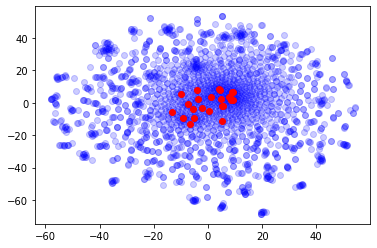

High perplexity


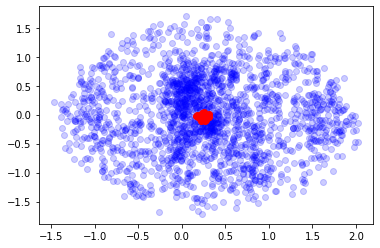

In [13]:
import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)
#tsne.fit(np.asarray(np_embeddings_high_dim, dtype='float64'))
lowdim = tsne.fit_transform(np.concatenate((np_embeddings_high_dim, np_trojan_embeddings_high_dim)))

#trojans_lowdim = tsne.transform(np_trojan_embeddings_high_dim)
#non_trojans_lowdim = tsne.transform(np_embeddings_high_dim)

#print(non_trojans_lowdim.shape)

print('Low perplexity')
plt.scatter(lowdim.transpose()[0, :np_embeddings_high_dim.shape[0]], lowdim.transpose()[1, :np_embeddings_high_dim.shape[0]], alpha = 0.2, c ="blue")
plt.scatter(lowdim.transpose()[0, np_embeddings_high_dim.shape[0]:], lowdim.transpose()[1, np_embeddings_high_dim.shape[0]:], alpha = 1.0, c ="red")

plt.show()


tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=1000)
#tsne.fit(np.asarray(np_embeddings_high_dim, dtype='float64'))
lowdim = tsne.fit_transform(np.concatenate((np_embeddings_high_dim, np_trojan_embeddings_high_dim)))

#trojans_lowdim = tsne.transform(np_trojan_embeddings_high_dim)
#non_trojans_lowdim = tsne.transform(np_embeddings_high_dim)

#print(non_trojans_lowdim.shape)

print('High perplexity')
plt.scatter(lowdim.transpose()[0, :np_embeddings_high_dim.shape[0]], lowdim.transpose()[1, :np_embeddings_high_dim.shape[0]], alpha = 0.2, c ="blue")
plt.scatter(lowdim.transpose()[0, np_embeddings_high_dim.shape[0]:], lowdim.transpose()[1, np_embeddings_high_dim.shape[0]:], alpha = 1.0, c ="red")

plt.show()

In [14]:
true_labels = np.concatenate((np.zeros(np_embeddings_high_dim.shape[0]), np.ones(np_trojan_embeddings_high_dim.shape[0])))
print(true_labels.shape)
embeddings = np.concatenate((np_embeddings_high_dim, np_trojan_embeddings_high_dim))
print(embeddings.shape)

(1967,)
(1967, 400)


In [15]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

epsilon = 5.0
min_samples = 2
cluster_method = 'xi'
metric = 'minkowski'

clust = OPTICS(max_eps=epsilon, min_samples=min_samples, cluster_method=cluster_method, metric=metric)
clust.fit(embeddings)

E:\Anaconda3\lib\site-packages\sklearn\cluster\_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(max_eps=5.0, min_samples=2)

In [16]:
num_clustered_points = clust.labels_[clust.labels_ != -1].shape
print('Number of clustered points = ', num_clustered_points)

clusters = set(clust.labels_)
num_clusters = len(clusters)
print('Num clusters =', num_clusters)


Number of clustered points =  (396,)
Num clusters = 164


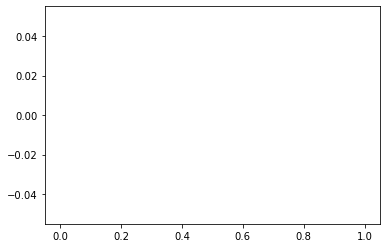

In [17]:
cluster_sizes = []
for cluster in clusters:
    if cluster == -1: #non-clustered
        continue
    
plt.hist(cluster_sizes, 5, facecolor='blue', alpha=0.5)
plt.show()

(1967,)
(1967, 400)
Number of clustered points =  (698,)
Num clusters = 10
[-1  5  1 ...  2  2  2]
Total # of trojan_nets:  24.0
[0.05968708 0.47470757]
cluster size = 132
trojan_nets in this cluster:  0.0
[0.01083599 0.18864837]
cluster size = 56
trojan_nets in this cluster:  0.0
[ 0.24972366 -0.05227619]
cluster size = 51
trojan_nets in this cluster:  24.0
[ 0.32107103 -0.22458242]
cluster size = 59
trojan_nets in this cluster:  0.0
[ 0.81835294 -0.3868012 ]
cluster size = 41
trojan_nets in this cluster:  0.0
[ 0.83898085 -0.91983646]
cluster size = 66
trojan_nets in this cluster:  0.0
[1.58129    0.11000121]
cluster size = 88
trojan_nets in this cluster:  0.0
[ 1.6688752 -0.3590319]
cluster size = 41
trojan_nets in this cluster:  0.0
[-0.97302413 -0.08901605]
cluster size = 164
trojan_nets in this cluster:  0.0


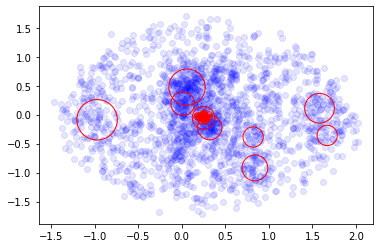

In [21]:
true_labels = np.concatenate((np.zeros(np_embeddings_high_dim.shape[0]), np.ones(np_trojan_embeddings_high_dim.shape[0])))
print(true_labels.shape)
embeddings_low = lowdim
print(embeddings.shape)

from sklearn.cluster import OPTICS, cluster_optics_dbscan

epsilon = 10.0
min_samples = 40
xi = 0.005
cluster_method = 'xi'
metric = 'minkowski'

clust = OPTICS(max_eps=epsilon, min_samples=min_samples, cluster_method=cluster_method, metric=metric, xi = xi)
clust.fit(embeddings_low)

num_clustered_points = clust.labels_[clust.labels_ != -1].shape
print('Number of clustered points = ', num_clustered_points)

clusters = set(clust.labels_)
num_clusters = len(clusters)
print('Num clusters =', num_clusters)
print(clust.labels_)

cluster_centroids = []
cluster_sizes = []
#nums_of_trojan_nets = []
print('Total # of trojan_nets: ', np.sum(true_labels))
for cluster in clusters:
    if cluster == -1: #non-clustered
        continue
    class_member_mask = clust.labels_ == cluster
    xy = embeddings_low[class_member_mask]

    centroid = np.mean(xy, axis=0)
    cluster_size = np.sum(class_member_mask)
    print(centroid)
    print('cluster size =', cluster_size)
    cluster_centroids.append(centroid)
    cluster_sizes.append(cluster_size)
    
    num_of_trojan_nets = np.sum(true_labels[class_member_mask])
    print('trojan_nets in this cluster: ', num_of_trojan_nets)

cluster_centroids = np.array(cluster_centroids)
cluster_sizes = np.array(cluster_sizes)

plt.scatter(embeddings_low.transpose()[0], embeddings_low.transpose()[1], alpha = 0.1, c ="blue")
plt.scatter(cluster_centroids.transpose()[0], cluster_centroids.transpose()[1], s = cluster_sizes * 10, facecolors = 'none', edgecolors = "red")
plt.scatter(lowdim.transpose()[0, np_embeddings_high_dim.shape[0]:], lowdim.transpose()[1, np_embeddings_high_dim.shape[0]:], alpha = 0.5, c ="red")

plt.show()